# Yamamoto's Method

Yamamoto's method is a semi-empirical method used for estimating the characteristic charge and equilibrium constant in the stoichiometric displacement model or in the linear region of the steric mass-action model.

To determine the parameters, the salt concentration at which a peak elutes $I_R$ for various gradient slopes is plotted over the normalized gradient slope.

$log(GH) = (\nu+1) \cdot log(I_R) - log(K_{eq} \cdot \lambda^\nu \cdot (\nu+1))$

The values for $GH$ and $c_{s,peak}$ are retrieved from the linear gradient experiments and the values for $\nu$ and $K_{eq}$ are fitted to the data.
The value of the characteristic charge and the equilibration constant can be used further to predict retention times. 

## Load Experimental Data
First, the experimental data needs to be read.
For this purpose, a `GradientExperiment` class is provided which takes the following arguments:
- time
- salt concentration
- protein concentration (multiple proteins are supported)
- gradient volume

For the Yamamoto method, at least two experiments are needed for the parameter estiamtion (linear regression).
However a third experiment is adviced for validation purposes.

For this tutorial, four experiments are used with two different protein sample.
The data can be found in `./experiments/single_protein`.


### Note on Experiments

It is important to consider the dead volume between the UV sensor and the conductivity sensor in the experimental system.
If this is not accounted for, the time offset will lead to inacurate results.

In practice, two tracer experiments are required.
One tracer experiment will produce a signal at the UV sensor, followed by another tracer detected by the conductivity sensor.
For example, Acetone could be used for the UV and NaCl for the conductivity measurement.
By subtracting the retention time of the system from the time of salt pulse, the time offset between the two sensors can be determined.

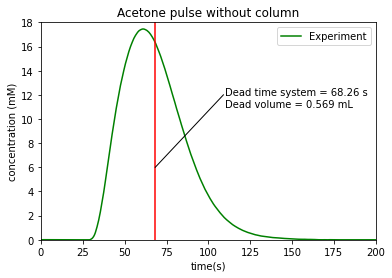   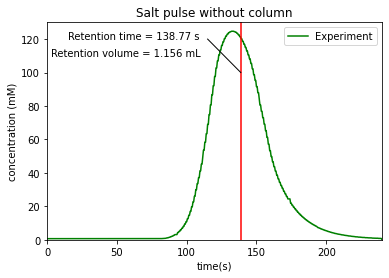

In [1]:
import numpy as np
from CADETProcess.tools.yamamoto import GradientExperiment
def create_experiment(file_name, gradient_volume):
    """CSV should have format of [time, salt, protein]."""

    data = np.loadtxt(file_name, delimiter=',')
    
    time = data[:, 0]
    c_salt = data[:, 1]
    c_protein = data[:, 2:]
    
    return GradientExperiment(time, c_salt, c_protein, gradient_volume)


experiment_1 = create_experiment('./experiments/single_protein/18.8mL.csv', 18.8e-6)
experiment_2 = create_experiment('./experiments/single_protein/37.6mL.csv', 37.6e-6)
experiment_3 = create_experiment('./experiments/single_protein/56.4mL.csv', 56.4e-6)
experiment_4 = create_experiment('./experiments/single_protein/75.2mL.csv', 75.2e-6)

experiments = [experiment_1, experiment_2, experiment_3, experiment_4]

To visualize the experiments, a plot method is provided.

(<Figure size 1000x600 with 2 Axes>,
 <AxesSubplot: xlabel='$Time / s$', ylabel='$c_{Protein} / mM$'>,
 <AxesSubplot: ylabel='$c_{Salt} / mM$'>)

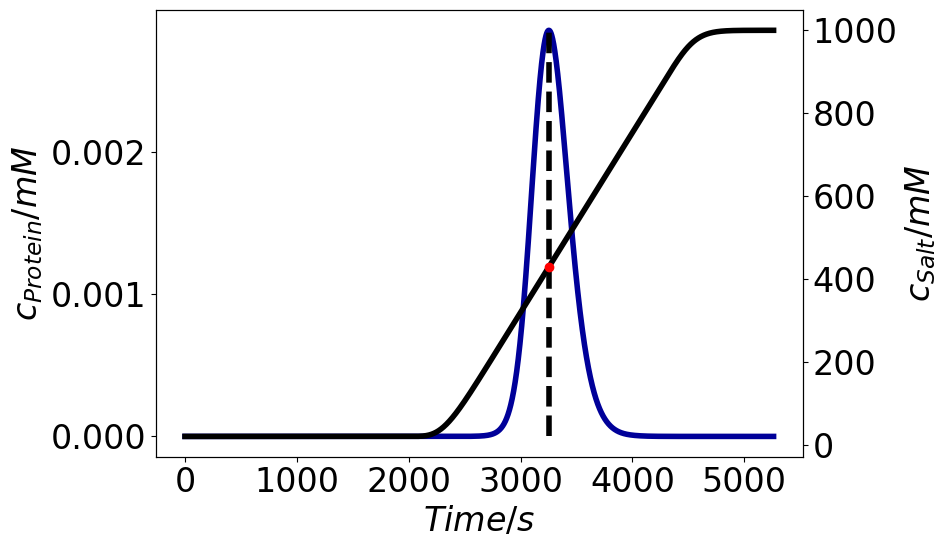

In [2]:
experiment_1.plot()

The experiments can also be plotted together.

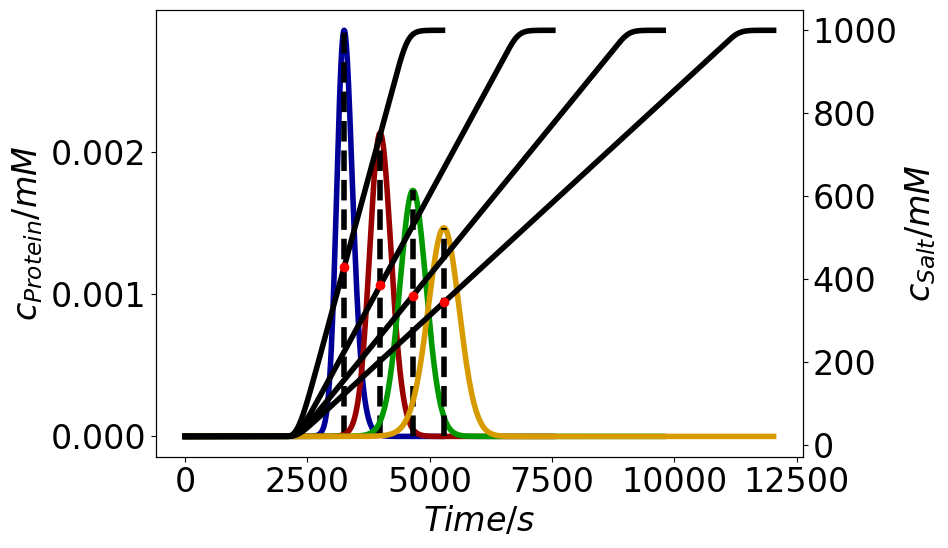

In [3]:
from CADETProcess.tools.yamamoto import plot_experiments

plot_experiments(experiments)

## Configure System

To run Yamamoto's method, initialize a `ComponentSystem`, a column (any model will work), and a `StericMassAction` binding model.

For the binding model, only the `capacity` is required.

Consider the following parameters:
- length: $0.1~m$
- diameter: $7.7~mm$
- bed porosity: $0.36$
- particle radius: $34 \cdot 10^{-6}~m$
- particle porosity: $0.85$

In [4]:
from CADETProcess.processModel import ComponentSystem
component_system = ComponentSystem(['Salt', 'A'])

from CADETProcess.processModel import StericMassAction
binding_model = StericMassAction(component_system)
binding_model.adsorption_rate = [1, 1]
binding_model.desorption_rate = [1, 1]
binding_model.capacity = 4.7 * 175

In [5]:
from CADETProcess.processModel import LumpedRateModelWithPores
column = LumpedRateModelWithPores(component_system, 'column')
column.binding_model = binding_model
column.length = 0.1
column.diameter = 0.0077
column.bed_porosity = 0.36
column.particle_radius = 34e-6
column.particle_porosity = 0.85

column.axial_dispersion = 1.5e-6
column.film_diffusion = [2e-6, 5e-7]

## Fit Parameters

To fit the parameters, pass the experiments and the column to the `fit_parameters` method which returns a `YamamotoResults` object.
This contains the results and provides a plot method to visualize the results.

[5.217277020469464]
[9.95783267946735e-05]


(<Figure size 1000x600 with 1 Axes>,
 <AxesSubplot: xlabel='Peak Salt Concentration $I_R$ / $M$', ylabel='Normalized Gradient Slope $GH$ / $M$'>)

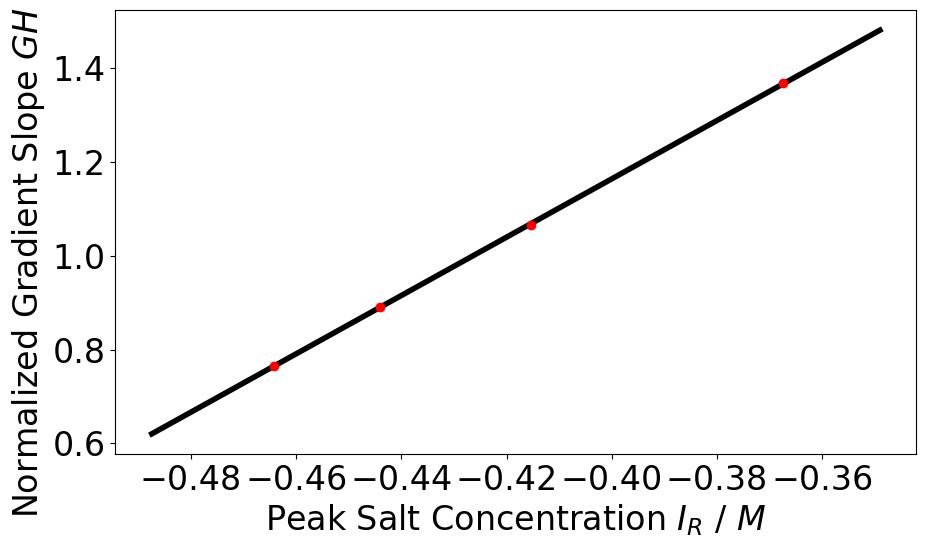

In [6]:
from CADETProcess.tools.yamamoto import fit_parameters
yamamoto_results = fit_parameters(experiments, column)

print(yamamoto_results.characteristic_charge)
print(yamamoto_results.k_eq)

yamamoto_results.plot()

## Bonus task: Compare with simulation

Besides the visualization of the fitted parameter from the experiments, there is also the option to use the characteristic charge $\nu$ and equilibrium constant $K_{eq}$ in a load wash elution simulation with the steric mass action isotherm. The structure of the model is quite simple as depicted in the figure below. The inlet will be used to modify the concentration in the column. The column is modelled with a general rate model.

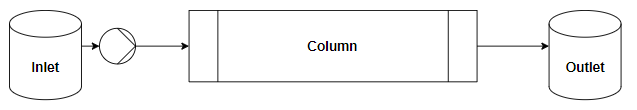